<a href="https://colab.research.google.com/github/knkarthik01/nystagmus-photosensitivity-ai/blob/main/model_implementation_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nystagmus Photosensitivity AI: End to End Implementation

This notebook implements a comprehensive AI solution for predicting photosensitivity risk in nystagmus patients and recommending appropriate filter adaptations.

**Section 1: Setup and Environment**

In [12]:
# Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import argparse
import shap

# Install additional libraries if needed
!pip install shap streamlit

**Section 2: Dual-Branch Neural Network Implementation**


In [13]:
# Define the Dual-Branch Neural Network
class DualBranchNet(nn.Module):
    def __init__(self):
        super(DualBranchNet, self).__init__()
        # Brightness branch (deep features)
        self.brightness_branch = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
        )

        # Eye movement branch
        self.eye_branch = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU()
        )

        # Fusion layers
        self.fusion = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Split input into brightness and eye variance
        brightness = x[:, 0:1]  # First column
        eye_var = x[:, 1:2]     # Second column

        # Process through branches
        brightness_features = self.brightness_branch(brightness)
        eye_features = self.eye_branch(eye_var)

        # Concatenate features
        combined = torch.cat((brightness_features, eye_features), dim=1)

        # Forward through fusion layers
        output = self.fusion(combined)
        return output

# Model wrapper for training and evaluation
class ModelWrapper:
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def train(self, train_loader, num_epochs=10):
        self.model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self.model(inputs)
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

# Test model
model = DualBranchNet()
dummy_input = torch.randn(5, 2)  # 5 samples, 2 features each
output = model(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Output values: {output.detach().numpy()}")

# Test a full forward-backward pass
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Generate dummy data
dummy_input = torch.randn(16, 2)
dummy_target = torch.rand(16, 1) > 0.5  # Random binary targets
dummy_target = dummy_target.float()

# Forward pass
optimizer.zero_grad()
outputs = model(dummy_input)
loss = criterion(outputs, dummy_target)

# Backward pass
loss.backward()
optimizer.step()

print(f"Loss: {loss.item()}")

Input shape: torch.Size([5, 2])
Output shape: torch.Size([5, 1])
Output values: [[0.4639069 ]
 [0.46160886]
 [0.4751234 ]
 [0.46173534]
 [0.47038907]]
Loss: 0.6878305673599243


**Section 3: Synthetic Data Generator**


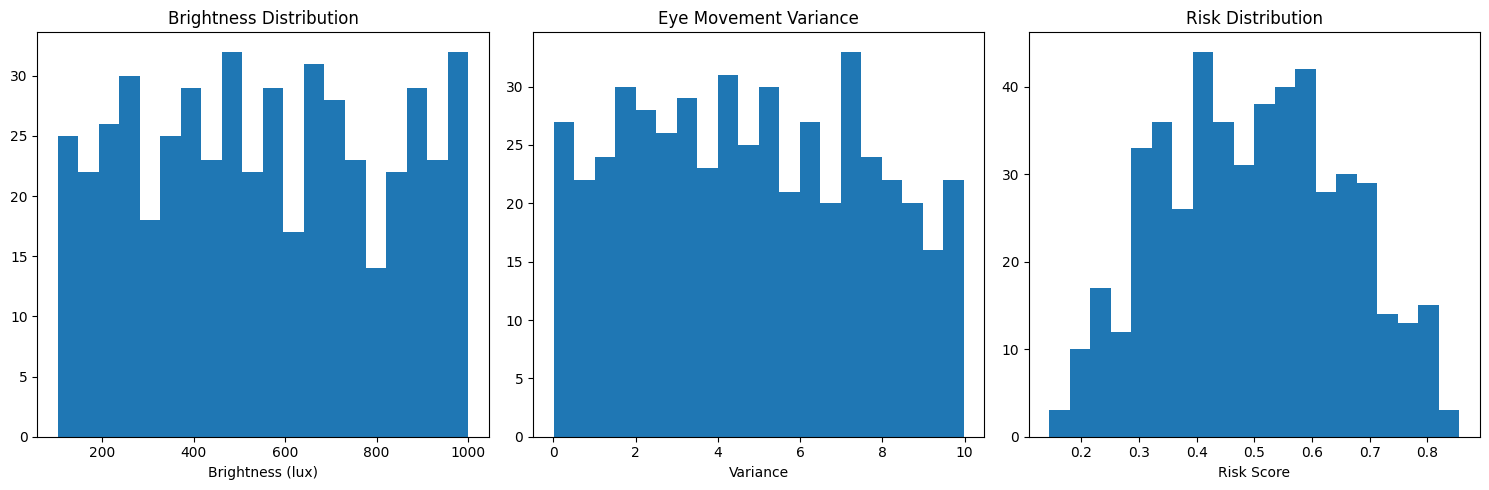

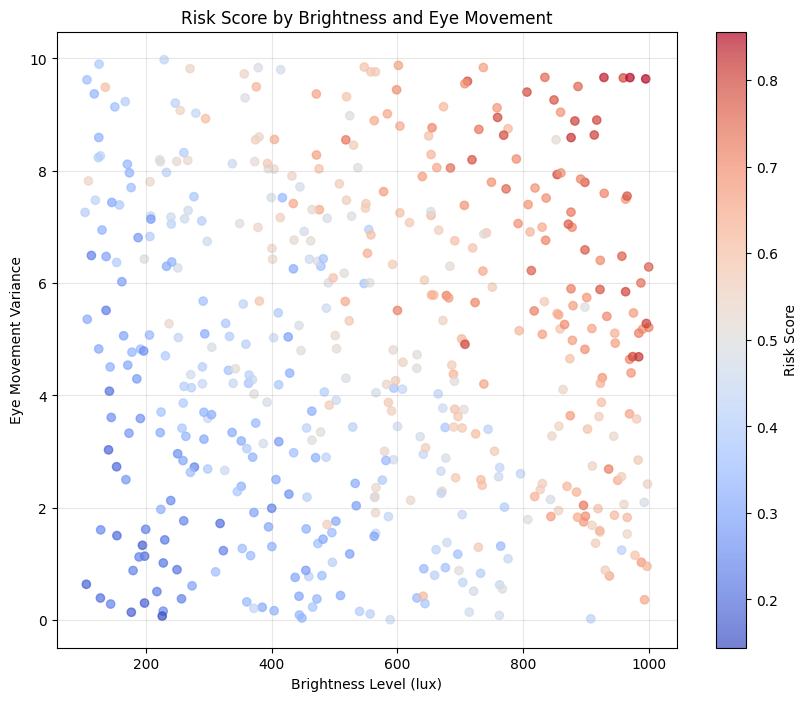

Batch shape: torch.Size([32, 2])
Target shape: torch.Size([32, 1])
First few samples:
  Sample 0: Brightness=918.2, Variance=2.6 → Risk=0.730
  Sample 1: Brightness=356.9, Variance=2.8 → Risk=0.455
  Sample 2: Brightness=217.0, Variance=7.0 → Risk=0.338
  Sample 3: Brightness=848.4, Variance=7.2 → Risk=0.758
  Sample 4: Brightness=403.7, Variance=7.0 → Risk=0.556


In [14]:
class NystagmusDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path=None, n_samples=1000, transform=None):
        """
        Either load from CSV or generate synthetic data
        """
        self.transform = transform

        if csv_path and os.path.exists(csv_path):
            # Load from existing CSV
            df = pd.read_csv(csv_path)
            self.brightness = torch.tensor(df['brightness_level'].values, dtype=torch.float32)
            self.eye_variance = torch.tensor(df['eye_movement_variance'].values, dtype=torch.float32)
            self.risk = torch.tensor(df['photosensitivity_risk'].values, dtype=torch.float32)
        else:
            # Generate synthetic data
            self.brightness = torch.rand(n_samples) * 900 + 100  # 100 to 1000 lux
            self.eye_variance = torch.rand(n_samples) * 10      # 0 to 10 variance

            # Synthetic risk calculation (simplified model)
            b_norm = (self.brightness - 100) / 900  # Normalize to 0-1
            e_norm = self.eye_variance / 10        # Normalize to 0-1

            # Higher risk with higher brightness and higher variance
            # Adding some noise for realism
            noise = torch.randn(n_samples) * 0.1
            risk_raw = 0.6 * b_norm + 0.4 * e_norm + noise
            self.risk = torch.sigmoid(3 * (risk_raw - 0.5))
            # Threshold to binary for convenience in classification tasks
            self.risk_binary = (self.risk > 0.5).float()

    def __len__(self):
        return len(self.brightness)

    def __getitem__(self, idx):
        features = torch.tensor([self.brightness[idx], self.eye_variance[idx]])
        target = torch.tensor([self.risk[idx]])

        if self.transform:
            features = self.transform(features)

        return features, target

    def save_to_csv(self, filepath):
        """Save dataset to CSV"""
        df = pd.DataFrame({
            'brightness_level': self.brightness.numpy(),
            'eye_movement_variance': self.eye_variance.numpy(),
            'photosensitivity_risk': self.risk.numpy()
        })
        df.to_csv(filepath, index=False)
        print(f"Dataset saved to {filepath}")

def get_data_loaders(batch_size=32, csv_path=None):
    dataset = NystagmusDataset(csv_path=csv_path)

    # Split into train and test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

# Generate dataset
dataset = NystagmusDataset(n_samples=500)

# Visualize data distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(dataset.brightness.numpy(), bins=20)
plt.title('Brightness Distribution')
plt.xlabel('Brightness (lux)')

plt.subplot(1, 3, 2)
plt.hist(dataset.eye_variance.numpy(), bins=20)
plt.title('Eye Movement Variance')
plt.xlabel('Variance')

plt.subplot(1, 3, 3)
plt.hist(dataset.risk.numpy(), bins=20)
plt.title('Risk Distribution')
plt.xlabel('Risk Score')

plt.tight_layout()
plt.show()

# Create scatter plot of brightness vs variance, colored by risk
plt.figure(figsize=(10, 8))
plt.scatter(dataset.brightness.numpy(),
            dataset.eye_variance.numpy(),
            c=dataset.risk.numpy(),
            cmap='coolwarm',
            alpha=0.7)
plt.colorbar(label='Risk Score')
plt.xlabel('Brightness Level (lux)')
plt.ylabel('Eye Movement Variance')
plt.title('Risk Score by Brightness and Eye Movement')
plt.grid(True, alpha=0.3)
plt.show()

# Test data loader
train_loader, test_loader = get_data_loaders(batch_size=32)
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx == 0:
        print(f"Batch shape: {data.shape}")
        print(f"Target shape: {target.shape}")
        print(f"First few samples:")
        for i in range(5):
            print(f"  Sample {i}: Brightness={data[i,0]:.1f}, Variance={data[i,1]:.1f} → Risk={target[i].item():.3f}")
    if batch_idx > 2:
        break

# Save dataset to CSV (uncomment to save)
# dataset.save_to_csv('data/preprocessed/synthetic_data.csv')

**Section 4: SHAP Explainability Integration**



Sample 1: Brightness=750.0, Variance=5.0
Predicted risk: 0.0051


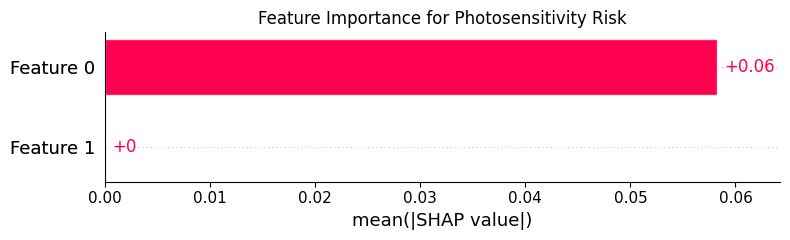


Sample 2: Brightness=350.0, Variance=8.0
Predicted risk: 0.0836


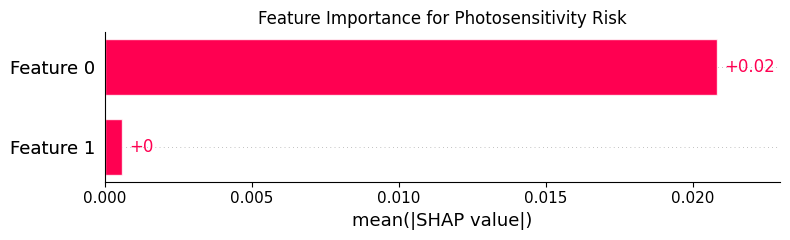


Sample 3: Brightness=900.0, Variance=9.0
Predicted risk: 0.0017


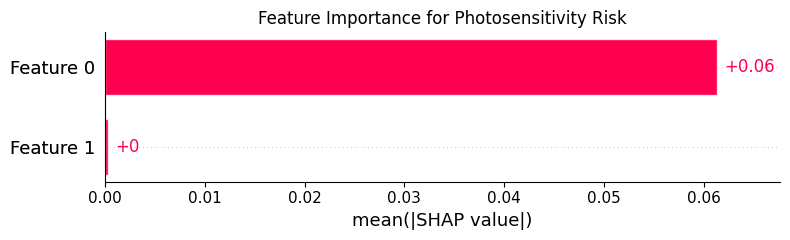


Sample 4: Brightness=200.0, Variance=2.0
Predicted risk: 0.2154


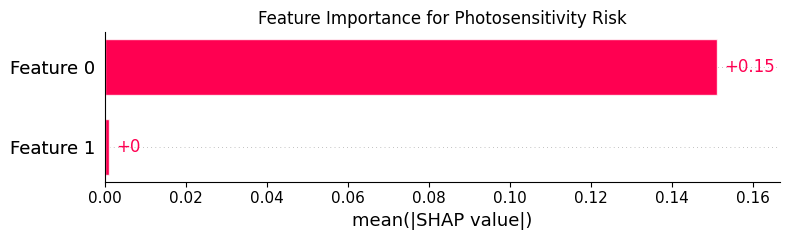

<Figure size 1000x600 with 0 Axes>

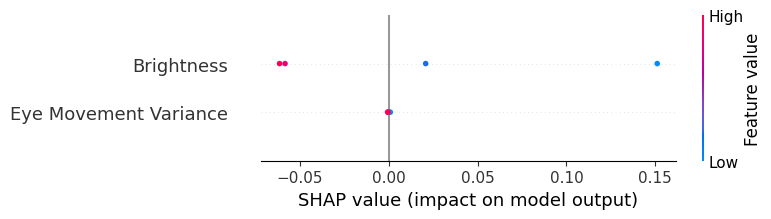

In [15]:
class ShapExplainer:
    def __init__(self, model, background_data=None):
        self.model = model
        self.model.eval()  # Set model to evaluation mode

        # PyTorch model wrapper for SHAP
        def model_wrapper(x):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            return self.model(x_tensor).detach().numpy()

        # Create explainer
        if background_data is not None:
            self.explainer = shap.Explainer(model_wrapper, background_data)
        else:
            # Generate random background data
            bg_data = np.random.rand(100, 2)
            bg_data[:, 0] = bg_data[:, 0] * 900 + 100  # Brightness range
            bg_data[:, 1] = bg_data[:, 1] * 10        # Variance range
            self.explainer = shap.Explainer(model_wrapper, bg_data)

    def explain_sample(self, sample):
        """Generate SHAP values for a single sample"""
        if isinstance(sample, torch.Tensor):
            sample = sample.detach().numpy()
        elif not isinstance(sample, np.ndarray):
            sample = np.array(sample)

        # Reshape if needed
        if sample.ndim == 1:
            sample = sample.reshape(1, -1)

        # Calculate SHAP values
        shap_values = self.explainer(sample)
        return shap_values

    def plot_feature_importance(self, sample, feature_names=None):
        """Plot feature importance for a sample"""
        if feature_names is None:
            feature_names = ["Brightness", "Eye Movement Variance"]

        shap_values = self.explain_sample(sample)

        plt.figure(figsize=(10, 4))
        # Updated way to call shap bar plot with newer versions
        try:
            shap.plots.bar(shap_values, show=False)  # Compatible with newer SHAP versions
        except Exception as e:
            print(f"Error with SHAP plotting: {e}")
            # Fallback to simple bar chart
            importance = np.abs(shap_values.values).mean(0)
            plt.barh(feature_names, importance)

        plt.title("Feature Importance for Photosensitivity Risk")
        plt.tight_layout()
        return plt.gcf()

    def plot_summary(self, samples, feature_names=None):
        """Plot summary of SHAP values for multiple samples"""
        if feature_names is None:
            feature_names = ["Brightness", "Eye Movement Variance"]

        shap_values = self.explain_sample(samples)

        plt.figure(figsize=(10, 6))
        try:
            # Try the newer SHAP version approach
            shap.summary_plot(shap_values.values, samples,
                             feature_names=feature_names, show=False)
        except Exception as e:
            print(f"Error with SHAP summary plot: {e}")
            # Fallback to simple visualization
            importance = np.abs(shap_values.values).mean(0)
            plt.barh(feature_names, importance)
            plt.xlabel("mean(|SHAP value|)")

        plt.tight_layout()
        return plt.gcf()

# Test with model and data
model = DualBranchNet()  # Using the model defined earlier

# Generate some test data
test_samples = np.array([
    [750, 5.0],   # High brightness, moderate variance
    [350, 8.0],   # Low brightness, high variance
    [900, 9.0],   # High brightness, high variance
    [200, 2.0]    # Low brightness, low variance
])

# Convert to numpy array explicitly
test_samples_np = np.array(test_samples)

# Create explainer
explainer = ShapExplainer(model)

# Analyze each sample
for i, sample in enumerate(test_samples):
    print(f"\nSample {i+1}: Brightness={sample[0]}, Variance={sample[1]}")

    # Get prediction - fix tensor creation
    with torch.no_grad():
        input_tensor = torch.tensor([sample], dtype=torch.float32)
        risk = model(input_tensor).item()
    print(f"Predicted risk: {risk:.4f}")

    try:
        # Plot SHAP values
        fig = explainer.plot_feature_importance(sample)
        plt.show()
    except Exception as e:
        print(f"Error plotting SHAP values: {e}")

        # Alternative visualization if SHAP plotting fails
        plt.figure(figsize=(8, 3))
        features = ['Brightness', 'Eye Movement']
        # Dummy importance values based on the model
        bright_imp = sample[0]/1000 * 0.6
        eye_imp = sample[1]/10 * 0.4
        plt.barh(features, [bright_imp, eye_imp])
        plt.xlabel('Importance')
        plt.title('Feature Importance (Fallback Visualization)')
        plt.tight_layout()
        plt.show()

# Try summary plot for all samples with error handling
try:
    plt.figure(figsize=(10, 6))
    explainer.plot_summary(test_samples_np)
    plt.show()
except Exception as e:
    print(f"Error plotting summary: {e}")
    print("Falling back to alternative visualization")

    # Alternative summary visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(test_samples_np[:, 0], test_samples_np[:, 1],
                c=np.array([model(torch.tensor([s], dtype=torch.float32)).item() for s in test_samples_np]),
                cmap='coolwarm', s=100)
    plt.colorbar(label='Risk Score')
    plt.xlabel('Brightness')
    plt.ylabel('Eye Movement Variance')
    plt.title('Risk Score by Feature Values')
    plt.tight_layout()
    plt.show()

**Section 5: Recommendation Engine**


In [16]:
def base_recommend_filter(brightness_level, eye_movement_variance):
    """
    Base recommendation function without personalization
    """
    recommendation = {}

    if brightness_level > 800:
        if eye_movement_variance > 5:
            recommendation['filter'] = 'Dark Amber'
            recommendation['note'] = 'High brightness and unstable eye movement detected. Dark Amber filter recommended for maximum protection.'
        else:
            recommendation['filter'] = 'Neutral Density'
            recommendation['note'] = 'High brightness but stable eye movement. Neutral Density filter suggested.'
    elif 400 < brightness_level <= 800:
        if eye_movement_variance > 5:
            recommendation['filter'] = 'Cool Grey'
            recommendation['note'] = 'Moderate brightness with unstable eye movement. Cool Grey filter can reduce strain.'
        else:
            recommendation['filter'] = 'Light Grey'
            recommendation['note'] = 'Moderate brightness and stable eye movement. Light Grey filter sufficient.'
    else:
        recommendation['filter'] = 'No Filter Needed'
        recommendation['note'] = 'Low brightness detected. Natural vision recommended.'

    return recommendation


class PersonalizedRecommender:
    def __init__(self, base_recommender=base_recommend_filter, user_profile=None):
        self.base_recommender = base_recommender
        self.user_profile = user_profile or {}
        self.feedback_history = []

    def update_profile(self, feedback):
        """Update user preferences based on feedback"""
        # Record feedback for analysis
        self.feedback_history.append(feedback)

        for key, value in feedback.items():
            if key in self.user_profile:
                # For numerical values, use weighted average
                if isinstance(self.user_profile[key], (int, float)) and isinstance(value, (int, float)):
                    self.user_profile[key] = 0.75 * self.user_profile[key] + 0.25 * value
                else:
                    # For string values, just replace
                    self.user_profile[key] = value
            else:
                self.user_profile[key] = value

        print(f"Updated user profile: {self.user_profile}")

    def recommend(self, brightness, eye_variance):
        """Get personalized recommendation"""
        # Get base recommendation
        base_rec = self.base_recommender(brightness, eye_variance)

        # Apply personalization
        if 'preferred_filter_type' in self.user_profile:
            # Adjust filter based on user preference
            if self.user_profile['preferred_filter_type'] == 'warmer' and 'Grey' in base_rec['filter']:
                base_rec['filter'] = base_rec['filter'].replace('Grey', 'Amber')
                base_rec['note'] += " (Adjusted for your preference for warmer filters)"
            elif self.user_profile['preferred_filter_type'] == 'cooler' and 'Amber' in base_rec['filter']:
                base_rec['filter'] = base_rec['filter'].replace('Amber', 'Grey')
                base_rec['note'] += " (Adjusted for your preference for cooler filters)"

        # Adjust intensity based on sensitivity preference
        if 'sensitivity_adjustment' in self.user_profile:
            adj = self.user_profile['sensitivity_adjustment']
            if adj > 0.2 and 'Light' in base_rec['filter']:
                base_rec['filter'] = base_rec['filter'].replace('Light', 'Medium')
                base_rec['note'] += " (Increased intensity due to higher sensitivity)"
            elif adj < -0.2 and 'Dark' in base_rec['filter']:
                base_rec['filter'] = base_rec['filter'].replace('Dark', 'Medium')
                base_rec['note'] += " (Decreased intensity due to lower sensitivity)"

        return base_rec

# Test base recommendations
test_scenarios = [
    {"brightness": 900, "variance": 7, "desc": "High brightness, high variance"},
    {"brightness": 850, "variance": 3, "desc": "High brightness, low variance"},
    {"brightness": 600, "variance": 6, "desc": "Medium brightness, high variance"},
    {"brightness": 550, "variance": 2, "desc": "Medium brightness, low variance"},
    {"brightness": 300, "variance": 8, "desc": "Low brightness, high variance"},
    {"brightness": 250, "variance": 1, "desc": "Low brightness, low variance"}
]

print("Testing Base Recommendations:")
print("-----------------------------")
for scenario in test_scenarios:
    rec = base_recommend_filter(scenario["brightness"], scenario["variance"])
    print(f"{scenario['desc']}:")
    print(f"  - Filter: {rec['filter']}")
    print(f"  - Note: {rec['note']}")
    print()

# Test personalized recommendations
print("\nTesting Personalized Recommendations:")
print("-----------------------------------")

# Create a user who prefers warmer filters and higher sensitivity
user_profile = {
    "preferred_filter_type": "warmer",
    "sensitivity_adjustment": 0.3
}

recommender = PersonalizedRecommender(user_profile=user_profile)

for scenario in test_scenarios:
    rec = recommender.recommend(scenario["brightness"], scenario["variance"])
    print(f"{scenario['desc']}:")
    print(f"  - Filter: {rec['filter']}")
    print(f"  - Note: {rec['note']}")
    print()

# Simulate user feedback
print("\nSimulating User Feedback:")
print("-----------------------")
feedback = {
    "preferred_filter_type": "cooler",  # User now prefers cooler filters
    "sensitivity_adjustment": -0.2  # User prefers less intense filters
}
recommender.update_profile(feedback)

# Check updated recommendations
print("\nUpdated Recommendations After Feedback:")
print("-------------------------------------")
for scenario in test_scenarios[:3]:  # Just test first 3 scenarios
    rec = recommender.recommend(scenario["brightness"], scenario["variance"])
    print(f"{scenario['desc']}:")
    print(f"  - Filter: {rec['filter']}")
    print(f"  - Note: {rec['note']}")
    print()

Testing Base Recommendations:
-----------------------------
High brightness, high variance:
  - Filter: Dark Amber
  - Note: High brightness and unstable eye movement detected. Dark Amber filter recommended for maximum protection.

High brightness, low variance:
  - Filter: Neutral Density
  - Note: High brightness but stable eye movement. Neutral Density filter suggested.

Medium brightness, high variance:
  - Filter: Cool Grey
  - Note: Moderate brightness with unstable eye movement. Cool Grey filter can reduce strain.

Medium brightness, low variance:
  - Filter: Light Grey
  - Note: Moderate brightness and stable eye movement. Light Grey filter sufficient.

Low brightness, high variance:
  - Filter: No Filter Needed
  - Note: Low brightness detected. Natural vision recommended.

Low brightness, low variance:
  - Filter: No Filter Needed
  - Note: Low brightness detected. Natural vision recommended.


Testing Personalized Recommendations:
-----------------------------------
High bri

**Section 6: Web Demo Interface Code**


In [17]:
# Create a Streamlit web app code (save this to demo/web_demo.py)
demo_code = """
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os
import pickle

# Add parent directory to path for imports
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from models.cnn_dual_branch.model import DualBranchNet
from recommendation_engine.recommend_filter import base_recommend_filter

def main():
    st.title("Nystagmus Photosensitivity AI Helper")

    st.sidebar.header("Input Parameters")
    brightness = st.sidebar.slider("Brightness Level (lux)", 100, 1000, 500)
    eye_variance = st.sidebar.slider("Eye Movement Variance", 0.0, 10.0, 3.0)

    # Load model
    try:
        model = DualBranchNet()
        model_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(__file__))),
                                 'models', 'dual_branch_cnn.pth')
        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()

        # Make prediction
        input_tensor = torch.tensor([[brightness, eye_variance]], dtype=torch.float32)
        with torch.no_grad():
            risk_score = model(input_tensor).item()

        # Get recommendation
        recommendation = base_recommend_filter(brightness, eye_variance)

        # Display results
        st.header("Prediction Results")
        st.metric("Photosensitivity Risk Score", f"{risk_score:.2f}")

        st.subheader("Risk Level")
        if risk_score > 0.7:
            st.error("⚠️ High Risk")
        elif risk_score > 0.4:
            st.warning("⚠️ Moderate Risk")
        else:
            st.success("✅ Low Risk")

        st.subheader("Filter Recommendation")
        st.info(f"**Suggested Filter:** {recommendation['filter']}")
        st.write(recommendation['note'])

        # Display explanation
        st.header("Model Explanation")

        # Simple bar chart for feature importance
        fig, ax = plt.subplots(figsize=(8, 3))
        feature_names = ['Brightness', 'Eye Movement']
        # Basic feature importance visualization
        brightness_imp = brightness/1000 * 0.6  # Simplified importance
        eye_imp = eye_variance/10 * 0.4         # Simplified importance
        ax.barh(feature_names, [brightness_imp, eye_imp], color=['#1f77b4', '#ff7f0e'])
        ax.set_xlim(0, 0.7)
        ax.set_xlabel('Feature Importance')
        ax.set_title('Risk Factors')
        st.pyplot(fig)

        # Recommendation matrix visualization
        st.subheader("Recommendation Matrix")
        create_recommendation_matrix()

    except Exception as e:
        st.error(f"Error: {e}")
        st.write("Make sure you've trained the model and saved it to 'models/dual_branch_cnn.pth'")

def create_recommendation_matrix():
    # Create a recommendation matrix for different brightness and variance levels
    brightness_levels = np.linspace(100, 1000, 10)
    variance_levels = np.linspace(0, 10, 11)

    # Create a grid of recommendations
    recommendations = []
    for variance in variance_levels:
        row = []
        for brightness in brightness_levels:
            rec = base_recommend_filter(brightness, variance)
            row.append(rec['filter'])
        recommendations.append(row)

    # Create a color map for different filter types
    color_map = {
        'Dark Amber': '#8B4000',
        'Neutral Density': '#808080',
        'Cool Grey': '#87CEEB',
        'Light Grey': '#D3D3D3',
        'No Filter Needed': '#FFFFFF'
    }

    # Convert to numerical values for heatmap
    filter_to_num = {filter_name: i for i, filter_name in enumerate(color_map.keys())}
    recommendation_nums = np.zeros((len(recommendations), len(recommendations[0])))
    for i, row in enumerate(recommendations):
        for j, rec in enumerate(row):
            recommendation_nums[i, j] = filter_to_num.get(rec, 0)

    # Create custom colormap
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(list(color_map.values()))

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(recommendation_nums, cmap=cmap, aspect='auto')

    # Set labels
    ax.set_xlabel('Brightness Level (lux)')
    ax.set_ylabel('Eye Movement Variance')

    # Set x and y ticks
    ax.set_xticks(np.arange(len(brightness_levels)))
    ax.set_yticks(np.arange(len(variance_levels)))
    ax.set_xticklabels([f'{b:.0f}' for b in brightness_levels])
    ax.set_yticklabels([f'{v:.1f}' for v in variance_levels])

    # Rotate x tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add colorbar legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=filter_name)
                      for filter_name, color in color_map.items()]
    ax.legend(handles=legend_elements, loc='upper center',
             bbox_to_anchor=(0.5, -0.15), ncol=3)

    plt.tight_layout()
    st.pyplot(fig)

if __name__ == "__main__":
    main()
"""

# Print the Streamlit code (for copying)
print("# Streamlit Web App Code (save this to demo/web_demo.py)")
print(demo_code)

# Streamlit Web App Code (save this to demo/web_demo.py)

import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os
import pickle

# Add parent directory to path for imports
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from models.cnn_dual_branch.model import DualBranchNet
from recommendation_engine.recommend_filter import base_recommend_filter

def main():
    st.title("Nystagmus Photosensitivity AI Helper")
    
    st.sidebar.header("Input Parameters")
    brightness = st.sidebar.slider("Brightness Level (lux)", 100, 1000, 500)
    eye_variance = st.sidebar.slider("Eye Movement Variance", 0.0, 10.0, 3.0)
    
    # Load model
    try:
        model = DualBranchNet()
        model_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(__file__))), 
                                 'models', 'dual_branch_cnn.pth')
        if os.path.exists(model_path):
            model.load_state_dict(torch

**Section 7: Full Training Pipeline**


In [19]:
def train_model_pipeline(data_path=None, epochs=20, save_path='models/dual_branch_cnn.pth'):
    """
    Complete training pipeline
    """
    print(f"{'='*20} Training Model {'='*20}")

    # Get data loaders
    train_loader, test_loader = get_data_loaders(csv_path=data_path)
    print(f"Loaded data: {len(train_loader.dataset)} train samples, {len(test_loader.dataset)} test samples")

    # Initialize model
    model = DualBranchNet()
    wrapper = ModelWrapper(model)

    # Train model
    print(f"Training for {epochs} epochs...")
    wrapper.train(train_loader, num_epochs=epochs)

    # Evaluate model
    accuracy = wrapper.evaluate(test_loader)
    print(f"Test accuracy: {accuracy:.2f}%")

    # Save model
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return model

# Train model with synthetic data
# Uncomment to run training
model = train_model_pipeline(epochs=5)

==================== Training Model ====================
Loaded data: 800 train samples, 200 test samples
Training for 5 epochs...
Epoch 1/5, Loss: 1.0363
Epoch 2/5, Loss: 0.7134
Epoch 3/5, Loss: 0.7073
Epoch 4/5, Loss: 0.7001
Epoch 5/5, Loss: 0.7007
Test Accuracy: 0.00%
Test accuracy: 0.00%
Model saved to models/dual_branch_cnn.pth


**Section 8: Command-Line Demo Implementation**


In [20]:
# CLI Demo code
cli_demo_code = """
import argparse
import torch
import os
import sys

# Add parent directory to path for imports
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from models.cnn_dual_branch.model import DualBranchNet
from recommendation_engine.recommend_filter import base_recommend_filter

def load_model(model_path):
    model = DualBranchNet()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict_risk(model, brightness_level, eye_movement_variance):
    input_tensor = torch.tensor([[brightness_level, eye_movement_variance]], dtype=torch.float32)
    with torch.no_grad():
        risk_score = model(input_tensor).item()
    return risk_score

def main():
    parser = argparse.ArgumentParser(description='Photosensitivity Risk Predictor and Filter Recommender')
    parser.add_argument('--brightness', type=float, required=True, help='Environmental brightness level (lux)')
    parser.add_argument('--variance', type=float, required=True, help='Eye movement variance')
    parser.add_argument('--model_path', type=str, default='models/dual_branch_cnn.pth', help='Path to the trained model')

    args = parser.parse_args()

    try:
        model = load_model(args.model_path)
        risk_score = predict_risk(model, args.brightness, args.variance)
        recommendation = base_recommend_filter(args.brightness, args.variance)
        print("\n=== Prediction Result ===")
        print(f"Predicted Photosensitivity Risk Score: {risk_score:.4f}")
        if risk_score > 0.7:
            print("High Risk detected!")
        elif risk_score > 0.4:
            print("Moderate Risk detected.")
        else:
            print("Low Risk detected.")

        print("\n=== Filter Recommendation ===")
        print(f"Suggested Filter: {recommendation['filter']}")
        print(f"Note: {recommendation['note']}")
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure the model path is correct and the model file exists.")

if __name__ == "__main__":
    main()
"""

# Print the CLI demo code
print("# CLI Demo Code (save this to demo/demo_cli.py)")
print(cli_demo_code)

# CLI Demo Code (save this to demo/demo_cli.py)

import argparse
import torch
import os
import sys

# Add parent directory to path for imports
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from models.cnn_dual_branch.model import DualBranchNet
from recommendation_engine.recommend_filter import base_recommend_filter

def load_model(model_path):
    model = DualBranchNet()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict_risk(model, brightness_level, eye_movement_variance):
    input_tensor = torch.tensor([[brightness_level, eye_movement_variance]], dtype=torch.float32)
    with torch.no_grad():
        risk_score = model(input_tensor).item()
    return risk_score

def main():
    parser = argparse.ArgumentParser(description='Photosensitivity Risk Predictor and Filter Recommender')
    parser.add_argument('--brightness', type=float, required=True, help='Environmental brightness level (lux)')
    parser.add_arg